##**InceptionV3**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the base model
inceptionv3_base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

# Add a custom head to the base model
x = inceptionv3_base_model.output
x = Flatten()(x)
x = Dense(4, activation='linear')(x)
model = Model(inputs=inceptionv3_base_model.input, outputs=x)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Callback to the model
save_inceptionv3_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionv3model.h5", 
    monitor='accuracy', 
    save_best_only=True, 
    verbose=1
)

# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35

# Train the model
inceptionv3_model_history= model.fit(image_generator(training_directory, batch_size, input_shape),
          steps_per_epoch=len(os.listdir(training_directory)) // batch_size,
          epochs=100,
          verbose=1,
          validation_data=image_generator(validation_directory, batch_size, input_shape),
          validation_steps=len(os.listdir(validation_directory)) // batch_size,
          callbacks=[save_inceptionv3_model])

# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionv3_model_history.pkl', 'wb') as f:
    pickle.dump(inceptionv3_model_history.history, f)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 5388.3018 - accuracy: 0.6907
Epoch 1: accuracy improved from -inf to 0.69074, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionv3model.h5
62/62 [==============================] - 81s 601ms/step - loss: 5388.3018 - accuracy: 0.6907 - val_loss: 9658.8711 - val_accuracy: 0.7604
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 476.5755 - accuracy: 0.8101
Epoch 2: accuracy improved from 0.69074 to 0.81006, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionv3model.h5
62/62 [==============================] - 30s 490ms/step - loss: 476.5755 - accuracy: 0.8101 - val_loss: 1018.5901 - val_accuracy: 0.8368
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 292.3337 - accuracy: 0.8701
Epoch 3: accuracy improved from 0.81006 to 0.87012, sav

###**Test the model for detecting output**

In [ ]:

import matplotlib.pyplot as plt

#Load model
InceptionV3Model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionv3model.h5')

# Directory Path
test_directory = r'/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

# Data Generator for test set
test_generator = image_generator(test_directory, batch_size, input_shape)
images, annotations = next(test_generator)

model_predictions = InceptionV3Model.predict(images)
for i in range(0, len(images), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for j in range(4):
        if i+j >= len(images):
            break
        image = images[i+j].astype('uint8')
        annotation = annotations[i+j]
        pred = model_predictions[i+j]
        X_min, Y_min, X_max, Y_max = annotation.astype('int')
        X_min1, Y_min1, X_max1, Y_max1 = pred.astype('int')
        cv2.rectangle(image, (X_min, Y_min), (X_max, Y_max), (0, 255, 0), 2)
        cv2.rectangle(image, (X_min1, Y_min1), (X_max1, Y_max1), (255,0,0), 2)
        cv2.putText(image, 'Number Plate', (X_min1, Y_min1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()


###**Performance Evaluation**

In [ ]:
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'
test_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

#Data Generator
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

test_generator = image_generator(test_directory, batch_size, input_shape)
test_steps = len(os.listdir(test_directory)) // batch_size

# Evaluate the performance on the validation set
validation_loss, validation_accuracy = InceptionV3Model.evaluate(val_generator, steps=val_steps)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the performance on the training set
training_loss, training_accuracy = InceptionV3Model.evaluate(train_generator, steps=training_steps)

print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

# Evaluate the performance on the test set
test_loss, test_accuracy = InceptionV3Model.evaluate(test_generator, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


18/18 [==============================] - 8s 321ms/step - loss: 205.5913 - accuracy: 0.8958
Validation Loss: 205.5912628173828
Validation Accuracy: 0.8958333134651184
62/62 [==============================] - 25s 405ms/step - loss: 38.7645 - accuracy: 0.9583
Training Loss: 38.7645149230957
Training Accuracy: 0.9582909345626831
9/9 [==============================] - 3s 395ms/step - loss: 237.7363 - accuracy: 0.8938
Test loss: 237.736328125
Test accuracy: 0.8937729001045227


###**Visual Representation on Training and Validation**

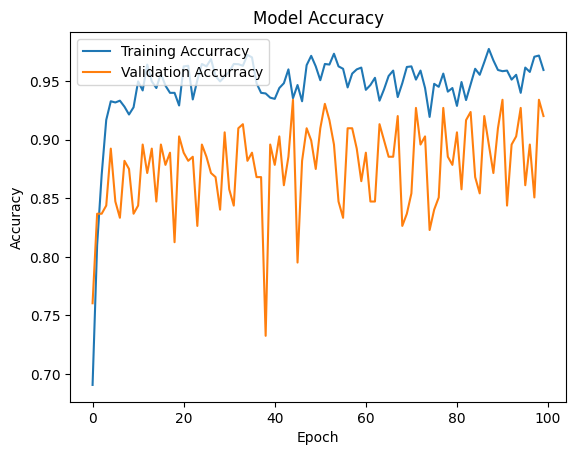

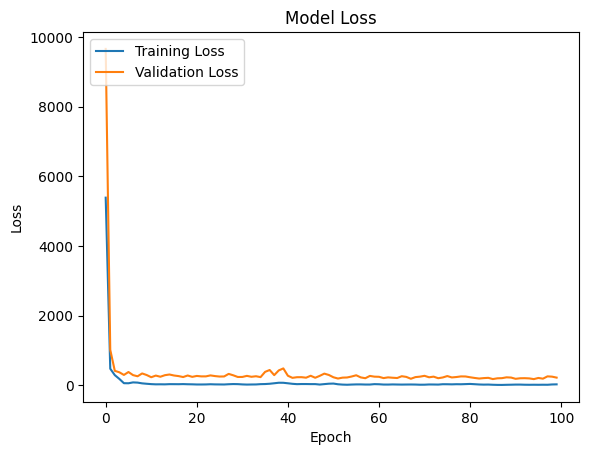

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionv3_model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accurracy', 'Validation Accurracy'], loc='upper left')
plt.show()

# Plot the loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()
